# Decision tree using XBoost

This notebook implements decision tree using XGBoost. We first train vivo scRNA-seq experiment. 
We use GridSearch to estimate the best parameters for the model. Afterwards we perform 10-fold cross
validation to validate and score the final model.

In [1]:
import glob
import os

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import xgboost as xgb
from pylab import rcParams
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from xgboost import plot_tree


# source: https://stackoverflow.com/questions/37340474/xgb-plot-tree-font-size-python
def plot_tree(xgb_model, filename, rankdir="UT"):
    """
    Plot the tree in high resolution
    :param xgb_model: xgboost trained model
    :param filename: the pdf file where this is saved
    :param rankdir: direction of the tree: default Top-Down (UT), accepts:'LR' for left-to-right tree
    :return:
    """
    import os

    import xgboost as xgb

    gvz = xgb.to_graphviz(
        xgb_model, num_trees=xgb_model.best_iteration, rankdir=rankdir
    )
    _, file_extension = os.path.splitext(filename)
    format = file_extension.strip(".").lower()
    data = gvz.pipe(format=format)
    full_filename = filename
    with open(full_filename, "wb") as f:
        f.write(data)

In [2]:
%run ../scripts/helpers-spatial.py

In [3]:
adata = anndata.read("../data/processed/01_raw_counts.h5ad")
metadata = pd.read_csv("../data/processed/02_metadata.csv", index_col=0)

adata = adata[metadata.index, spatial_genes]
adata.obs = metadata
adata.obs.cluster_names = adata.obs.cluster_names.astype("category")

In [4]:
adata = nzm(adata)

In [5]:
adata

AnnData object with n_obs × n_vars = 6279 × 25
    obs: 'orig.ident', 'nUMI', 'nGene', 'Well_ID', 'Well_coordinates', 'plate_ID', 'Subject_ID', 'Amp_batch_ID', 'Cell_barcode', 'Pool_barcode', 'Batch', 'Condition', 'SampleName', 'Stage', 'Source', 'SubGroup', 'Day', 'Amp_batch_ID.1', 'Well_ID.1', 'Protocol', 'FACS_index', 'percent.mito', 'percent.ercc', 'nCount_RNA', 'nFeature_RNA', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.1.4', 'seurat_clusters', 'cluster_names'

## Training

In [6]:
train_obs = adata.obs.groupby("cluster_names").sample(
    frac=0.7, replace=False, random_state=random_seed
)
train_obs.cluster_names = train_obs.cluster_names.astype("category")

# train
train_df = adata[train_obs.index].to_df().copy()
train_labels = np.array(train_obs.cluster_names == "InterVE", dtype=int)
# train_labels = train_obs.cluster_names.cat.codes.values

# test
test_obs = adata.obs[~adata.obs.index.isin(train_obs.index)].copy()
test_obs.cluster_names = test_obs.cluster_names.astype("category")
test_df = adata[test_obs.index].to_df()
test_labels = np.array(test_obs.cluster_names == "InterVE", dtype=int)
# test_labels = test_obs.cluster_names.cat.codes.values

In [7]:
data_dmatrix = xgb.DMatrix(data=train_df, label=train_labels)

In [8]:
model = xgb.XGBClassifier(
    booster="gbtree",
    n_estimators=100,
    use_label_encoder=False,
    max_depth=12,
    learning_rate=0.1,
    objective="binary:logistic",
    nthread=6,
    random_state=random_seed,
    eval_metric="auc",
    validate_parameters=True,
)

In [9]:
# # GridSearch
# from sklearn.model_selection import GridSearchCV

# test_params = {
#     "max_depth": [3, 4, 6, 8, 10],
#     "learning_rate": [0.1, 0.2, 0.3],
#     "n_estimators": [10, 30, 50, 100]
# }

# model = GridSearchCV(estimator=model, param_grid=test_params)
# model.fit(train_df, train_labels)

In [10]:
# print(f"Best max_depth {model.best_params_}")

In [11]:
model = xgb.XGBClassifier(
    booster="gbtree",
    use_label_encoder=False,
    n_estimators=30,
    max_depth=3,
    learning_rate=0.1,
    objective="binary:logistic",
    nthread=6,
    random_state=random_seed,
    eval_metric="auc",
    validate_parameters=True,
)

In [12]:
model.fit(X=train_df, y=train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=30, n_jobs=6, nthread=6,
              num_parallel_tree=1, random_state=12345, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=True, verbosity=None)

In [13]:
preds = model.predict(test_df)

In [14]:
rmse = np.sqrt(mean_squared_error(test_labels, preds))
accuracy = accuracy_score(test_labels, preds)
f1 = f1_score(test_labels, preds, average="micro")

print(f"RMSE: {rmse}")
print(f"Accuracy: {accuracy}")
print(f"F1-score (micro): {f1}")

RMSE: 0.11519391939602286
Accuracy: 0.9867303609341825
F1-score (micro): 0.9867303609341825


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

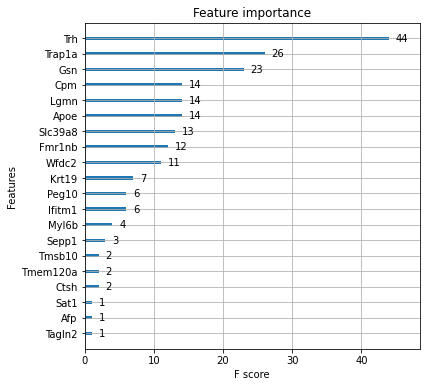

In [15]:
# features
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
xgb.plot_importance(model, ax=ax, max_num_features=20)
# fig.savefig("figures/feature_importance.svg")

In [16]:
model.save_model("../data/processed/11_dt.model.json")

## Cross validation

In [17]:
from xgboost import cv

data_dmatrix = xgb.DMatrix(
    data=adata.to_df(), label=np.array(adata.obs.cluster_names == "InterVE", dtype=int)
)

params = {
    "objective": "binary:logistic",
    #     "colsample_bytree": 0.3,
    #     "learning_rate": 0.1,
    "max_depth": 3,
    #     "alpha": 10,
}

xgb_cv = cv(
    dtrain=data_dmatrix,
    params=params,
    nfold=10,
    num_boost_round=50,
    early_stopping_rounds=10,
    metrics="auc",
    as_pandas=True,
)

In [18]:
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.892330,0.004498,0.886785,0.052910
1,0.922682,0.026361,0.907759,0.054725
2,0.949597,0.014498,0.937655,0.047197
3,0.959166,0.008568,0.947561,0.036316
4,0.968199,0.001920,0.956564,0.023342


Text(0.5, 0, 'Round')

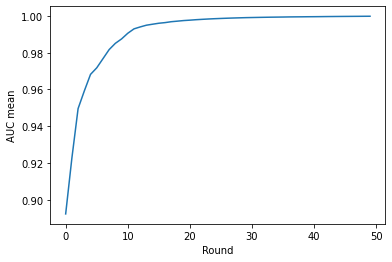

In [19]:
plt.plot(xgb_cv.iloc[:, 0])
plt.ylabel("AUC mean")
plt.xlabel("Round")

## Plot decision tree

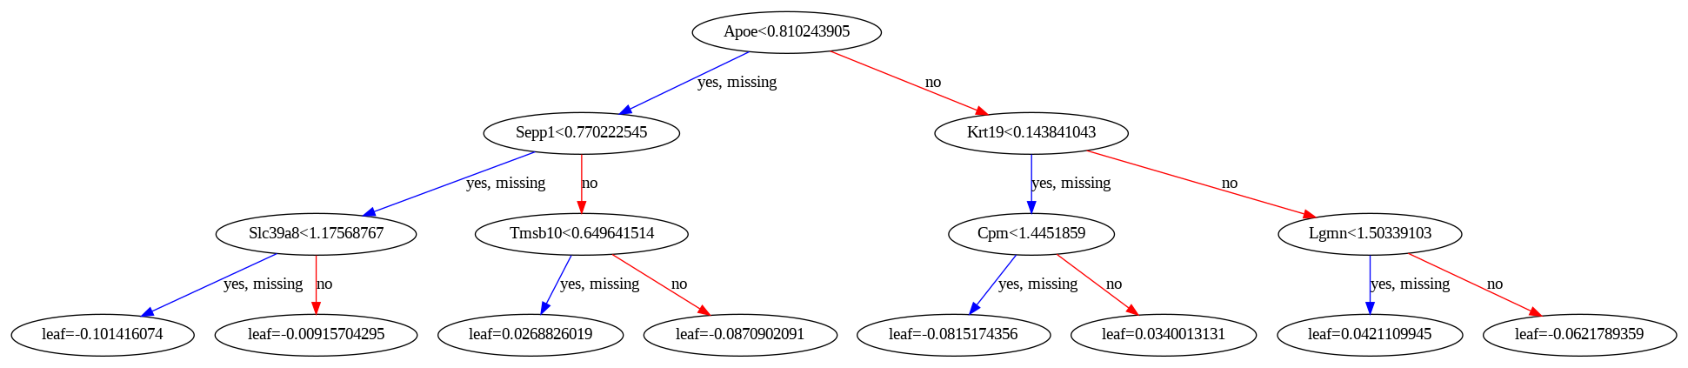

In [36]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(model, num_trees=model.best_iteration, ax=ax)
plt.show()

## Heatmap Supp. Fig 6

In [22]:
vivo = sc.read("../data/processed/01_raw_counts.h5ad")
metadata = pd.read_csv("../data/processed/02_metadata.csv", index_col=0)
vivo = vivo[metadata.index]
vivo.obs = metadata

sc.pp.normalize_total(vivo, target_sum=10_000)
sc.pp.log1p(vivo)
vivo.raw = vivo

... storing 'orig.ident' as categorical
... storing 'Well_coordinates' as categorical
... storing 'Amp_batch_ID' as categorical
... storing 'Cell_barcode' as categorical
... storing 'Pool_barcode' as categorical
... storing 'Batch' as categorical
... storing 'Condition' as categorical
... storing 'Stage' as categorical
... storing 'Source' as categorical
... storing 'SubGroup' as categorical
... storing 'Day' as categorical
... storing 'Phase' as categorical
... storing 'cluster_names' as categorical


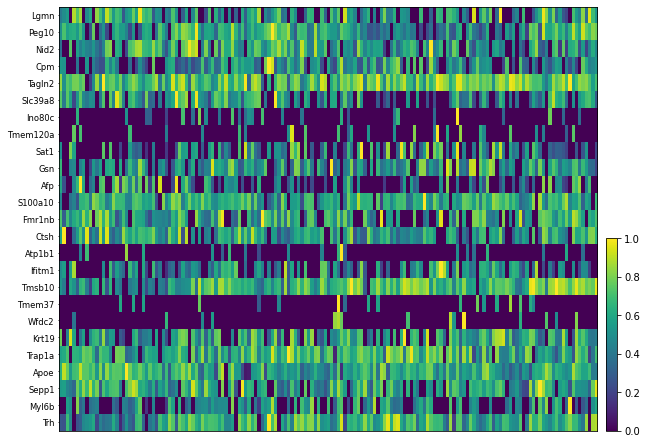

In [27]:
cherry_picked_genes = [
    "Lgmn",
    "Peg10",
    "Nid2",
    "Cpm",
    "Tagln2",
    "Slc39a8",
    "Ino80c",
    "Tmem120a",
    "Sat1",
    "Gsn",
    "Afp",
    "S100a10",
    "Fmr1nb",
    "Ctsh",
    "Atp1b1",
    "Ifitm1",
    "Tmsb10",
    "Tmem37",
    "Wfdc2",
    "Krt19",
    "Trap1a",
    "Apoe",
    "Sepp1",
    "Myl6b",
    "Trh",
]

vivo_heat = vivo[vivo.obs.query("cluster_names == 'InterVE' & Day == 'e7.5'").index, cherry_picked_genes].copy()
sc.pl.heatmap(
    vivo_heat,
    vivo_heat.var_names,
    groupby="cluster_names",
    swap_axes=True,
    figsize=[10, 8],
    standard_scale="var",
)

In [1]:
!jupyter nbconvert --to html 11_dt.ipynb --output-dir="../reports"

[NbConvertApp] Converting notebook 11_dt.ipynb to html
[NbConvertApp] Writing 870012 bytes to ../reports/11_dt.html
